In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from data import read_preprocessed_data
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
import seaborn as sns

color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

data_scaled = read_preprocessed_data()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


In [10]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

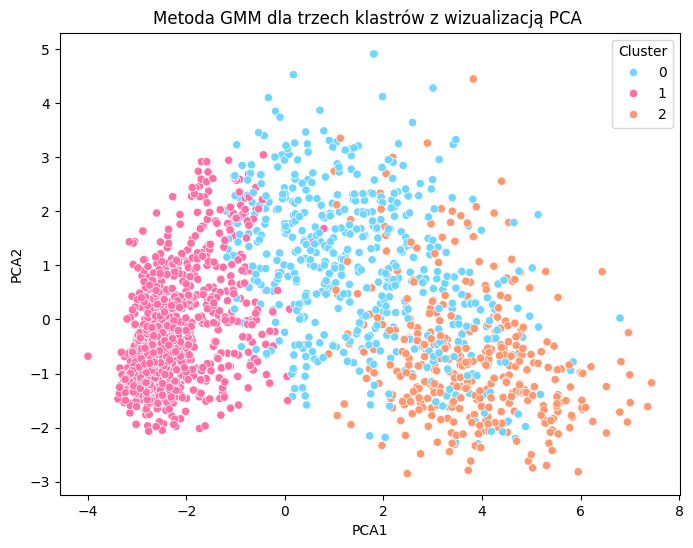

In [11]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [12]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.45
PCA2:  0.1
Suma wyjaśnionej wariancji:  0.55


In [13]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,62714.003466,35209.285038,75862.637532
Kidhome,0.10052,0.774621,0.023136
Teenhome,0.731369,0.473485,0.200514
Recency,46.994801,49.303977,50.948586
MntWines,446.523397,49.409091,655.305913
MntFruits,35.561102,5.466856,65.813107
MntMeatProducts,169.511265,26.340909,494.977425
MntFishProducts,48.767474,8.214962,98.854594
MntSweetProducts,36.259827,5.573864,67.52711
MntGoldProds,65.435714,17.139205,72.822155


In [14]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla czterech klastrów z wizualizacją PCA ')

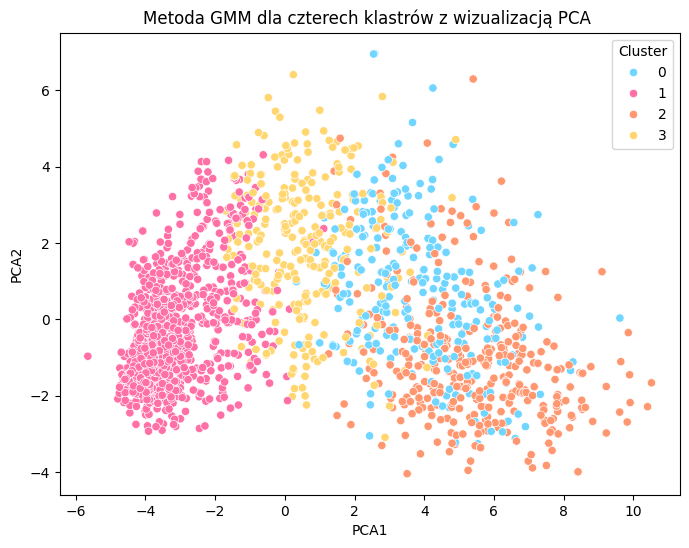

In [15]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_pallete = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_pallete
)
plt.title("Metoda GMM dla czterech klastrów z wizualizacją PCA ")

In [16]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.58
PCA2:  0.13
Suma wyjaśnionej wariancji:  0.71


In [17]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów
cluster_summary.transpose()


c:\dadada4\Mad\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2,3
Income,67997.79021,35209.285038,75862.637532,57521.003436
Kidhome,0.101399,0.774621,0.023136,0.099656
Teenhome,0.611888,0.473485,0.200514,0.848797
Recency,45.36014,49.303977,50.948586,48.601375
MntWines,535.423077,49.409091,655.305913,359.151203
MntFruits,53.00356,5.466856,65.813107,18.418343
MntMeatProducts,222.293706,26.340909,494.977425,117.635739
MntFishProducts,69.91587,8.214962,98.854594,27.982453
MntSweetProducts,51.214791,5.573864,67.52711,21.561821
MntGoldProds,75.301302,17.139205,72.822155,55.739637
